In [0]:
import tarfile
from google.colab import drive
# drive.mount('/content/drive/')
!fusermount -u drive
drive.mount('/content/drive')

In [2]:
# !pip install tensorflow==1.15.2
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(tf.__version__)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0
Found GPU at: /device:GPU:0


In [0]:
import pandas as pd
from sklearn.utils import shuffle

# Download the file using the `gsutil` CLI
# !gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./                            8231

# Read, shuffle, and preview the data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.drop(columns=['original_tags'])
data = data.dropna()

data = shuffle(data, random_state=22)
data.head()

In [0]:
train_size = int(len(data) * .8)

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

In [0]:
from tensorflow.keras.preprocessing import text

tokenizer = text.Tokenizer(num_words=400)
tokenizer.fit_on_texts(train_qs)

bag_of_words_train = tokenizer.texts_to_matrix(train_qs)
bag_of_words_test = tokenizer.texts_to_matrix(test_qs)

In [0]:
tags_split = [tags.split(',') for tags in data['tags'].values]


In [0]:
# Create the encoder
from sklearn.preprocessing import MultiLabelBinarizer

tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)

# Split the tags into train/test
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

VOCAB_SIZE = 400
num_tags = 5

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
# model.add(tf.keras.layers.Dense(25, activation='relu'))
# model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

def my_init(shape, dtype=None):
#    return model_22
    return tf.random.normal(shape, dtype=dtype)

model.add(tf.keras.layers.Dense(num_tags, kernel_initializer=my_init, input_shape=(VOCAB_SIZE,), activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['categorical_accuracy'])

# categorical_accuracy checks to see if the index of the maximal true value is equal to the index of the maximal predicted value.

In [0]:
model_3 = model.fit(bag_of_words_train, train_tags, epochs=15, batch_size=128, validation_split=0.1)
output_3 = model.evaluate(bag_of_words_test, test_tags, batch_size=128)

In [0]:
# Start from here

# Data split
import numpy as np

agentN_lr = 10
paraN_lr = VOCAB_SIZE 
dataN_total = 150000
dataN_lr = dataN_total/agentN_lr

M_lr_local = np.zeros((int(dataN_lr), VOCAB_SIZE, agentN_lr))
for i in range(agentN_lr):
  M_lr_local[:, :, i] = np.asarray(bag_of_words_train[i*int(dataN_lr):(i+1)*int(dataN_lr), :])

tags_lr_local = np.zeros((int(dataN_lr), num_tags, agentN_lr))
for i in range(agentN_lr):
  tags_lr_local[:, :, i] = np.asarray(train_tags[i*int(dataN_lr):(i+1)*int(dataN_lr), :] )


In [0]:
# Logistic regression function

def Logistic_grad(Mi, tagi, xi, num_tags, VOCAB_SIZE, numer, i ):

  def my_init1(shape, dtype=None):
    return tf.transpose(xi)

  model = tf.keras.models.Sequential()
  shape = (VOCAB_SIZE, num_tags)
  model.add(tf.keras.layers.Dense(num_tags, kernel_initializer=my_init1, input_shape=(VOCAB_SIZE,), activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=numer/(i+1)), metrics=['accuracy'])
  train_model = model.fit(Mi, tagi, epochs=1, batch_size=128, validation_split=0.1)
  test_output = model.evaluate(bag_of_words_test, test_tags, batch_size=128)
  model_1=model.trainable_variables
  model_11=tf.convert_to_tensor(
    model_1[0], dtype=None, dtype_hint=None, name=None)
  model_diff = model_11-tf.transpose(xi)
  output = tf.transpose(model_diff, perm=None,name=None)
  return output, test_output


In [0]:
# Logistic regression model

from numpy import *
import random

def Logistic_dgd_dp(mu, num_tags, VOCAB_SIZE, N, sel_num, sigma, mode):
  x_a1_lr=ts2=tf.Variable(tf.random.normal([num_tags, VOCAB_SIZE, agentN_lr]))
  # x_a1_lr=ts2=tf.Variable(tf.zeros([num_tags, VOCAB_SIZE, agentN_lr]))
  y_a1_lr=tf.Variable(tf.zeros((num_tags, VOCAB_SIZE, agentN_lr)))
  loss_a1_lr=[]
  correct=[]
  grad_k_a1_lr=tf.Variable(tf.zeros((num_tags, VOCAB_SIZE, agentN_lr)))
  numer=0.01
  epsilon = 0.01

  for i in range(int(N)):
    print(i)

    test_out = np.zeros((agentN_lr, 2))
    for j in range(agentN_lr):
      if mode=='dp':
        noise = tf.Variable(tf.random.normal([num_tags, VOCAB_SIZE ]))
        grad_k_a1_lr_j, test_out_j = Logistic_grad(M_lr_local[:, :, j], tags_lr_local[:, :, j], x_a1_lr[:, :, j], num_tags, VOCAB_SIZE, numer, i)
        tf.compat.v1.assign(grad_k_a1_lr[:, :, j], grad_k_a1_lr_j+noise*(numer/(i+1)))
        test_out[j] = [test_out_j[k]+test_out[j, k] for k in range(2)]
      else:
        grad_k_a1_lr_j, test_out_j = Logistic_grad(M_lr_local[:, :, j], tags_lr_local[:, :, j], x_a1_lr[:, :, j] , num_tags, VOCAB_SIZE, numer, i)
        tf.compat.v1.assign(grad_k_a1_lr[:, :, j], grad_k_a1_lr_j)
        test_out[j] = [test_out_j[k]+test_out[j, k] for k in range(2)]
    loss_a1_lr.append(np.average(test_out[:, 0]))
    correct.append(np.average(test_out[:, 1]))

    print(tf.math.reduce_max(tf.math.abs(grad_k_a1_lr)))
    

    M_x=np.zeros((agentN_lr, num_tags*VOCAB_SIZE))
    M_y=np.zeros((agentN_lr, num_tags*VOCAB_SIZE))

    for j in range(agentN_lr):
      x_j=x_a1_lr[:, :, j].numpy()
      y_j=y_a1_lr[:, :, j].numpy()
      M_x[j, :]=x_j.reshape((1, num_tags*VOCAB_SIZE))
      M_y[j, :]=y_j.reshape((1, num_tags*VOCAB_SIZE))

    M_x0=np.zeros((agentN_lr, num_tags*VOCAB_SIZE))
    M_y0=np.zeros((agentN_lr, num_tags*VOCAB_SIZE))
    for j in range(num_tags*VOCAB_SIZE):
      # Construct Matrix M
      A=np.random.random((agentN_lr, agentN_lr))
      B=np.random.random((agentN_lr, agentN_lr))
      A_new=np.array([A[k] for k in range(agentN_lr)])
      B_new=np.array([B[k] for k in range(agentN_lr)])
      for m in range(agentN_lr):
        w_list=list(range(agentN_lr))
        w_list.pop(m)
        if sel_num=='full':
          w_num=0
        elif sel_num=='none':
          w_num=agentN-1
        else:
          w_num=sel_num
        w_id=random.sample(w_list,w_num)
        A_new[m][w_id]=0
        B_new[m][w_id]=0
      A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN_lr)]) # Make it row-stochastic
      B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN_lr)]) #Make it column-stochastic
      B=B.T
      M_up=np.hstack((A, epsilon*np.eye(agentN_lr)))
      M_down=np.hstack((np.eye(agentN_lr)-A, B-epsilon*np.eye(agentN_lr)))
      M_new=np.vstack((M_up, M_down))
        
      M_xy_col=np.hstack((M_x[:, j], M_y[:, j]))
      M_xy=M_new.dot(M_xy_col.T)
      M_x0[:, j]=M_xy[:agentN_lr]
      M_y0[:, j]=M_xy[(agentN_lr):]

    for j in range(agentN_lr):
      x_a1_lr_j = np.reshape(np.array(M_x0[j, :]), (num_tags, VOCAB_SIZE))+grad_k_a1_lr[:, :, j].numpy()
      tf.compat.v1.assign(x_a1_lr[:, :, j], tf.convert_to_tensor(np.float32(x_a1_lr_j)) )
      y_a1_lr_j = np.reshape(np.array(M_y0[j, :]), (num_tags, VOCAB_SIZE))
      tf.compat.v1.assign(y_a1_lr[:, :, j], tf.convert_to_tensor(np.float32(y_a1_lr_j)))

    # x_a1_lr = tf.convert_to_tensor(x_a1_lr, dtype=None, dtype_hint=None, name=None )
  return loss_a1_lr, correct




In [0]:
# Run experiments for different parameters

mu = 0.0001
N = 15
sigma = 1

l1, c1 = Logistic_dgd_dp(mu, num_tags, VOCAB_SIZE, N, 'full', sigma, 'f')
l2, c2 = Logistic_dgd_dp(mu, num_tags, VOCAB_SIZE, N, 'full', sigma, 'dp')
l3, c3 = Logistic_dgd_dp(mu, num_tags, VOCAB_SIZE, N, 5, sigma, 'f')
l4, c4 = Logistic_dgd_dp(mu, num_tags, VOCAB_SIZE, N, 5, sigma, 'dp')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


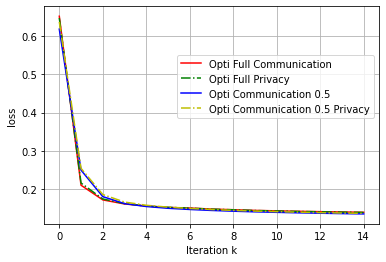

In [36]:
# Plot

import matplotlib.pyplot as plt

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
y_axis.sort()    
plt.clf()
plt.grid()
# plt.yscale('log')

plt.plot(l1, color='r', linestyle="-", label ="Opti Full Communication")
plt.plot(l2, color='g', linestyle="-.", label ="Opti Full Privacy")
plt.plot(l3, color='b', linestyle="-", label ="Opti Communication 0.5")
plt.plot(l4, color='y', linestyle="-.", label ="Opti Communication 0.5 Privacy")

plt.xlabel('Iteration k')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(1.00,0.8),loc='upper right')

# plt.savefig('/content/drive/My Drive/Colab Notebooks/dp_results/lr_loss.eps',dpi=600,format='eps')

In [0]:
# Privacy functions

import numpy as np
import matplotlib.pyplot as plt

# import tensorflow.compat.v1 as tf1

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent

def compute_epsilon(steps, noise_multiplier, sampling_probability, delta = 1e-5):
    """Computes epsilon value for given hyperparameters."""
    if noise_multiplier == 0.0:
        return float('inf')
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
    # Delta is set to 1e-5 because MNIST has 60000 training points.
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]



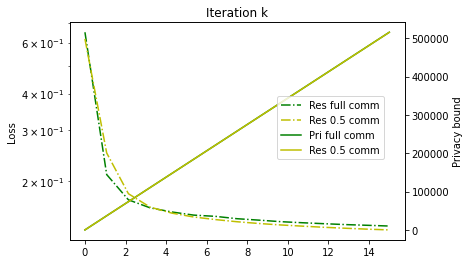

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [41]:
# Privacy plot

sigma = 2
steps_list = np.linspace(start=0, stop=15, num=15)
noise_multiplier = sigma/500 # sigma=noise_multiplier * D
sampling_probability = 0.5
delta = 1e-5


y1 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier,
                    sampling_probability=1,
                    delta=delta) for st in steps_list]

y2 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier,
                    sampling_probability=0.5,
                    delta=delta) for st in steps_list]

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
# ax1.set_ylim(top=0.1)
T = 15
ax1.plot(steps_list[:T], l1[:T], color='g', linestyle = '-.', label = 'Res full comm')
ax1.plot(steps_list[:T], l3[:T], color='y', linestyle = '-.', label = 'Res 0.5 comm')
ax1.set_ylabel('Loss')
ax1.set_title("Iteration k")
# ax1.legend(bbox_to_anchor=(1.00,0.65),loc='upper right')

ax2 = ax1.twinx()  # this is the important function
ax2.plot(steps_list[:T], y1[:T], color = 'g', label = 'Pri full comm' )
ax2.plot(steps_list[:T], y2[:T], color = 'y', label = 'Res 0.5 comm')
ax2.set_ylabel('Privacy bound')

# ax2.set_xlabel('Iteration k')
fig.legend(bbox_to_anchor=(0.9,0.6),loc='upper right')
plt.show()

fig.savefig('/content/drive/My Drive/Colab Notebooks/dp_results/lr_dp_res_pri.eps',dpi=600,format='eps')